# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [28]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import imutils
import pydash
from random import *

## Parameters

In [29]:
imagePath = "./Brieferstellung/test1.png"
# Kernel
blurring = 0
dilateErode = 15
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode-1,dilateErode), "uint8")
# 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [2.0,2.2]
stampZone = [74,40]
margin = 15
stampMinSize=[20,26]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

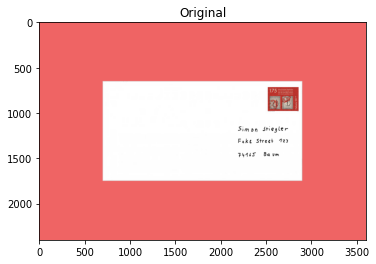

In [30]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")

## For Rotating the Picture
https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

In [31]:
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the image file")
# args, unknown =  ap.parse_args(argv[1:])

Text(0.5, 1.0, 'blurred')

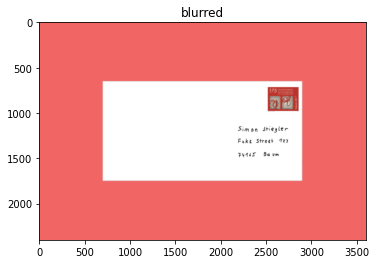

In [32]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image, (blurring,blurring) , 2, 2,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

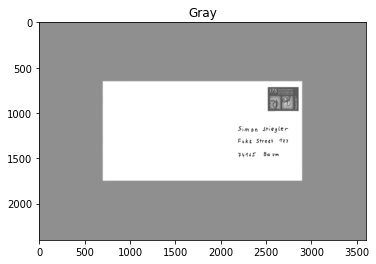

In [33]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

Text(0.5, 1.0, 'Canny')

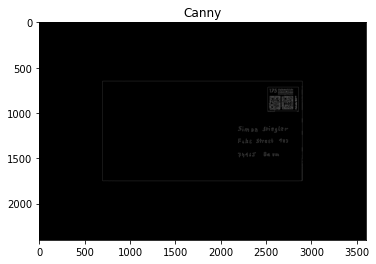

In [34]:
canny = cv2.Canny(gray,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

Text(0.5, 1.0, 'dilate')

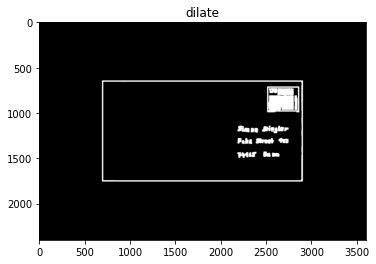

In [35]:
dilate = cv2.dilate(canny,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("dilate")

Text(0.5, 1.0, 'erode')

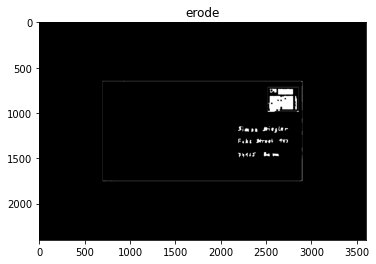

In [36]:
erode = cv2.erode(dilate,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("erode")

In [37]:
img,contours,hierachy = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [38]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

13178
13176
4368
2458
1250
674


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [39]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(contours):
    for contour in contours:
    #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        width = minArea[1][0]
        height = minArea[1][1]
        scale = width/height
        if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]):
            letter = {
                "width": int(width),
                "height" : int(height),
                "centerX" : int(minArea[0][0]),
                "centerY" : int(minArea[0][1]),
                "contour": contour
                }
            return letter

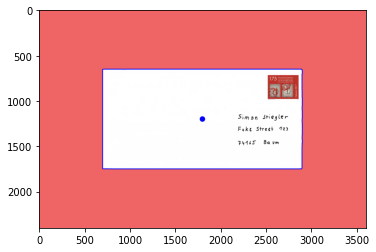

In [40]:
letterValue = findLetter(contours)
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = showImage.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (0, 0, 255), 7) 
plt.imshow(highlightedContour)

## ROI of Letter

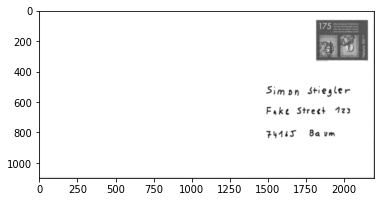

In [41]:
xStart = int(letterValue["centerX"]-letterValue["width"]/2)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2)
yStart = int(letterValue["centerY"]-letterValue["height"]/2)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2)
letter = gray[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")

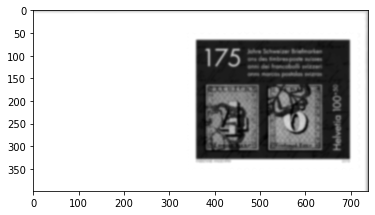

In [42]:
pixelPerMM = letterValue["width"]/C_5_6_Metrics[0]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")

### Check if stamp is there

In [43]:
def checkStamp(img):
    imgStamp,cStamp,hStamp = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for index,contour in enumerate(cStamp):
        #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        height = int(minArea[1][1])
        width = int(minArea[1][0])
        # stamp minSize 22x28
        contourWidth = width/pixelPerMM
        contourHeigth =height/pixelPerMM
        if(contourWidth>stampMinSize[0] and contourHeigth>stampMinSize[1]):
            print(True)

In [44]:
stamp = checkStamp(rightTop)

True


## Get AddressField

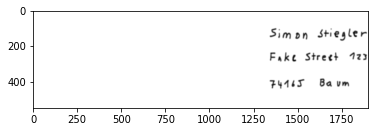

In [45]:
height, width = letter.shape
pixelMargin = margin*pixelPerMM
addressField = letter.copy()
startX = int(pixelMargin)
endX = int(width-pixelMargin)
startY = int(stampZone[1]*pixelPerMM)
endY = int(height-pixelMargin)
addressField = addressField[startY:endY,startX:endX]
plt.imshow(addressField, cmap="gray")

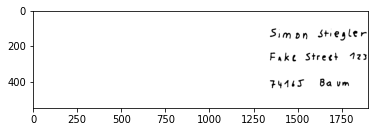

In [46]:
th, binAF = cv2.threshold(addressField, 128, 255, cv2.THRESH_BINARY)
plt.imshow(binAF,cmap="gray")

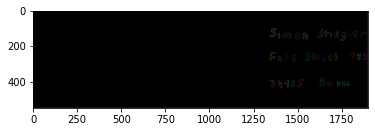

In [47]:
imgAF,contoursAF,hierachyAF = cv2.findContours(binAF,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
heightAF,widthAF = addressField.shape
plt.imshow(imgAF,cmap="gray")
contourImg = np.zeros((heightAF,widthAF,3))
for index,contour in enumerate(contoursAF):
    r = random()
    g = random()
    b = random()
    cv2.drawContours(contourImg,contoursAF , index, (r,g,b), 1) 
plt.imshow(contourImg)

## Display Function
https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

In [48]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Extract the Characters

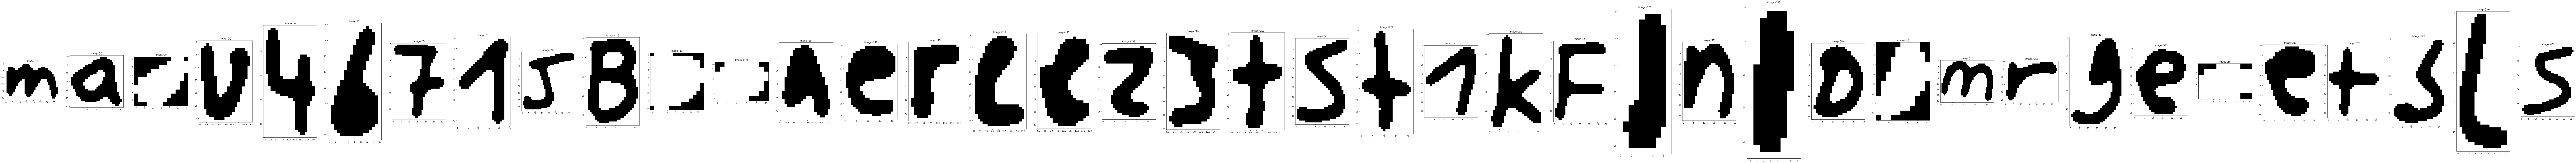

In [49]:
characters = []
for index,contour in enumerate(contoursAF):
    # [x,y,width,height]
    rect = cv2.boundingRect(contour)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    if(width>5 and height>5 and width!=widthAF):
        img = binAF[y:y+height,x:x+width]
        character = {
                "img": img,
                "width" : width,
                "height" : height,
                "x" : x,
                "y": y
                }
        characters.append(character)
        # plt.imshow(character,cmap="gray")
show_images(pydash.map_(characters,"img")) 

In [50]:
centerPoints = characters
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

AttributeError: 'silent_list' object has no attribute 'map_'

In [24]:
mean_width = np.sum(pydash.map_(characters,"width"))/len(characters)
mean_height = np.sum(pydash.map_(characters,"height"))/len(characters)
def sortX(element):
    return element["y"]
centerPoints.sort(key=sortX)
print(mean_width)
print(mean_height)
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

24.425
35.15
[1342, 1788, 1614, 1650, 1813, 1707, 1858, 1741, 1487, 1415, 1719, 1684, 1530, 1390, 1496, 1795, 1424, 1343, 1707, 1544, 1580, 1872, 1835, 1675, 1470, 1638, 1608, 1389, 1626, 1498, 1424, 1635, 1342, 1466, 1389, 1723, 1662, 1753, 1633, 1670]
[98, 100, 104, 108, 111, 113, 118, 118, 121, 121, 121, 122, 123, 125, 134, 234, 234, 234, 235, 236, 237, 242, 243, 246, 247, 250, 250, 257, 382, 386, 390, 390, 391, 392, 393, 396, 397, 399, 405, 406]


## Get the 

15.0
13.0
12.0
[[98.0, 142.0], [230.0, 274.0], [362.0, 318.0]]


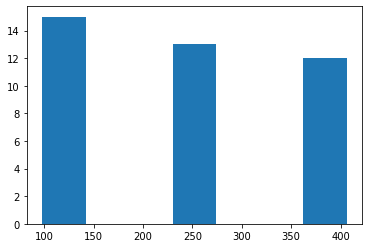

In [61]:
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
amount, binEdges, _  = plt.hist(pydash.map_(characters,["y"]), bins="auto")
rows = []
for i,yValue in enumerate(amount):
    if(yValue>0):
        print(yValue)
        lastIndex = len(amount)-1
        if lastIndex==i:
            rows.append([binEdges[i],binEdges[i-1]])
        else:
            rows.append([binEdges[i],binEdges[i+1]])


print(rows)

### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [25]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

In [26]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()